In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# CO2 flux

##### RUN:
/data/tjarniko/results/j22
##### DATE:  Jan17_2019
##### description of point: 

calculate intermediate calculations for co2 flux. 
check units/check that numbers make sense with literature

from PISCES code, adapted in p4zflx


      DO jj = 1, jpj
         DO ji = 1, jpi
            ! Compute CO2 flux for the sea and air
            zfld = satmco2(ji,jj) * patm(ji,jj) * tmask(ji,jj,1) * chemc(ji,jj) * zkgco2(ji,jj)   ! (mol/L) * (m/s)
            zflu = zh2co3(ji,jj) * tmask(ji,jj,1) * zkgco2(ji,jj)                                   ! (mol/L) (m/s) ?
            
            zco2flx(ji,jj) = zfld-zflu
            
            !oce_co2(ji,jj) = ( zfld - zflu ) * rfact2 * e1e2t(ji,jj) * tmask(ji,jj,1) * 1000.
            ! compute the trend
            tra(ji,jj,1,jpdic) = tra(ji,jj,1,jpdic) + ( zfld - zflu ) * rfact2 / fse3t(ji,jj,1)
         END DO
      END DO

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
#import all the things

import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import cmocean as cm
from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools)
import xarray as xr 
import subprocess 
import cmocean
from matplotlib import reload
import glob
import netCDF4 as nc
import VIZ_plots as VP

%matplotlib inline

Oxygen is exchanged with the atmosphere using the parameterization
of Wanninkhof (1992) to compute the gas exchange
coefficient. The atmospheric concentration of oxygen
is constant over time and space and cannot be specified by
the user. As for CO2, no air–sea fluxes are allowed when the
ocean is covered by sea ice (see Eq. 82).

In [4]:
reload(VP)

<module 'VIZ_plots' from '/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/MOCSY_and_FLUX/VIZ_plots.py'>

#### Available functions from VP

    two_panel_plot(surfdat_1,surfdat_2,tit1,tit2,t_cmap,xsize,ysize,vmin,vmax,clabel,bigtit)
    animate_surf(hrly_dat,tit,v_min,v_max,t_cmap)

In [5]:
resdir = '/data/tjarniko/results/j21o/'
ptrc = 'SalishSea_1ts_20171026_20171026_ptrc_T.nc'
grid = 'SalishSea_1ts_20171026_20171026_grid_T.nc'
tracers = nc.Dataset(resdir + ptrc)
tracersp = nc.Dataset(resdir + grid)
#print(tracers)
# print(tracersp)
print(tracers)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: SalishSea_1ts_20171026_20171026
    description: biogeochemical variables
    title: biogeochemical variables
    Conventions: CF-1.6
    timeStamp: 2019-Jan-22 02:11:18 GMT
    uuid: 8051143c-f7e1-4b0b-9067-f3eeb90be75d
    dimensions(sizes): axis_nbounds(2), x(398), y(898), nvertex(4), deptht(40), time_counter(3)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 bounds_lon(y,x,nvertex), float32 bounds_lat(y,x,nvertex), float32 area(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float32 nitrate(time_counter,deptht,y,x), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 ammonium(time_counter,deptht,y,x), float32 silicon(time_counter,deptht,y,x), float32 diatoms(time_counter,deptht,y,x), float32 

In [6]:
chemc = tracers.variables['of_chemc'][0,:,:]
zkgco2 = tracers.variables['of_zkgco2'][0,:,:]
patm = tracers.variables['of_patm'][0,:,:]
#patm = patm/101325
co2_surf = tracers.variables['dissolved_inorganic_carbon'][0,0,:,:]
oce_co2 = tracers.variables['oce_co2'][0,:,:]
wm = tracers.variables['wind_mag'][0,:,:]
sal = tracersp.variables['vosaline'][0,0,:,:]
temp = tracersp.variables['votemper'][0,0,:,:]
satmco2 = tracers.variables['zfld16'][0,:,:]
f_co2w = tracers.variables['f_co2w'][0,:,:]
f_co2flux = tracers.variables['f_co2flux'][0,:,:]

In [7]:
print('chemco2')
print(np.min(chemc))
print(np.max(chemc))
print('zkgco2')
print(np.min(zkgco2))
print(np.max(zkgco2))
print('patm')
print(np.min(patm))
print(np.max(patm))
print('oce_co2')
print(np.min(oce_co2))
print(np.max(oce_co2))
print('f_co2flux')
print(np.min(f_co2flux))
print(np.max(f_co2flux))
print('co2_surf')
print(np.min(co2_surf))
print(np.max(co2_surf))
print('wind_mag')
print(np.min(wm))
print(np.max(wm))
print('satmco2')
print(np.min(satmco2))
print(np.max(satmco2))
print('f_co2w')
print(np.min(f_co2w))
print(np.max(f_co2w))


chemco2
0.0
4.9624e-08
zkgco2
0.0
4.48514e-05
patm
101839.0
102280.0
oce_co2
-0.0024805
0.0
f_co2flux
-0.00177997
0.000286187
co2_surf
0.0
2159.1
wind_mag
0.0
8.5762
satmco2
287.0
287.0
f_co2w
0.0308637
1e+23


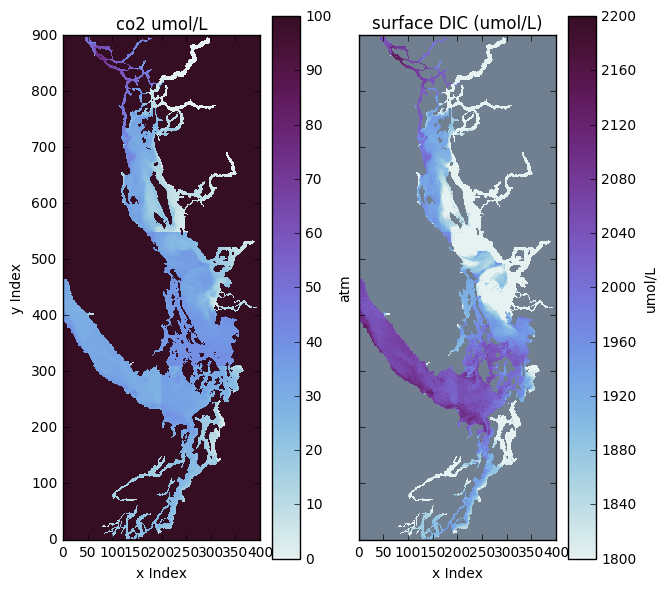

In [8]:
VP.two_panel_plot(f_co2w,co2_surf,'co2 umol/L','surface DIC (umol/L)',\
                  cm.cm.dense,7,7,0.0,100.0,1800,2200,'atm','umol/L','')


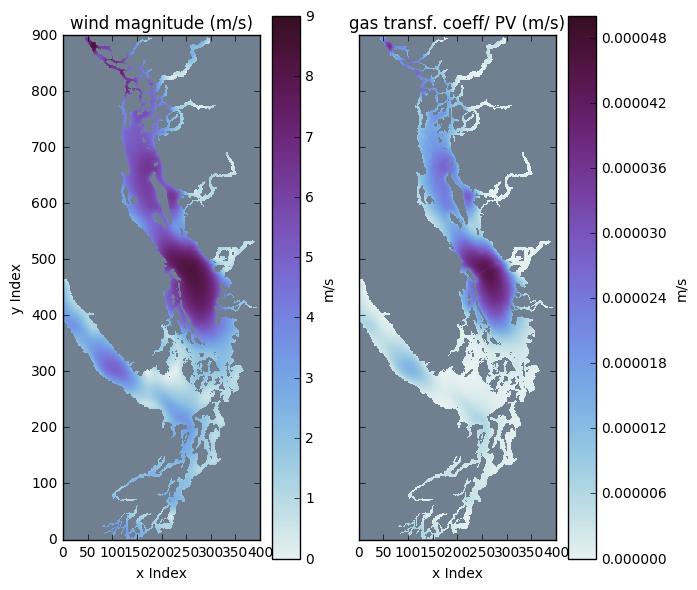

In [9]:
VP.two_panel_plot(wm,zkgco2,'wind magnitude (m/s)','gas transf. coeff/ PV (m/s)',\
                  cm.cm.dense,7,7,0,9,0,5e-5,'m/s','m/s','')


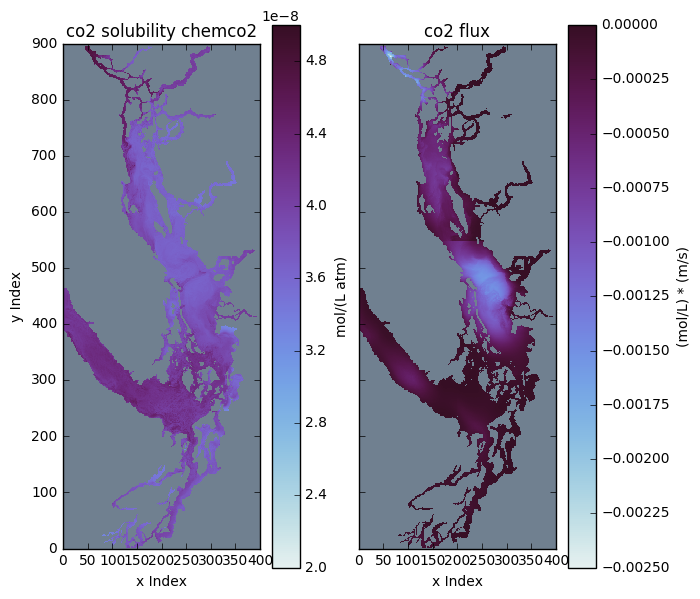

In [10]:
VP.two_panel_plot(chemc,oce_co2,'co2 solubility chemco2','co2 flux',\
                  cm.cm.dense,7,7,2e-08,5e-08,-0.0025,0,'mol/(L atm)','(mol/L) * (m/s)','')

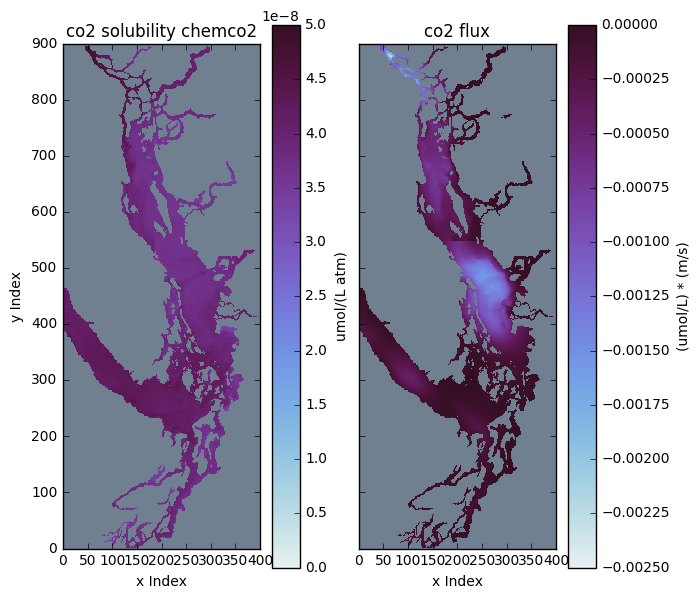

In [11]:
VP.two_panel_plot(chemc,oce_co2,'co2 solubility chemco2','co2 flux',\
                  cm.cm.dense,7,7,0,5e-08,-0.0025,0,'umol/(L atm)','(umol/L) * (m/s)','')

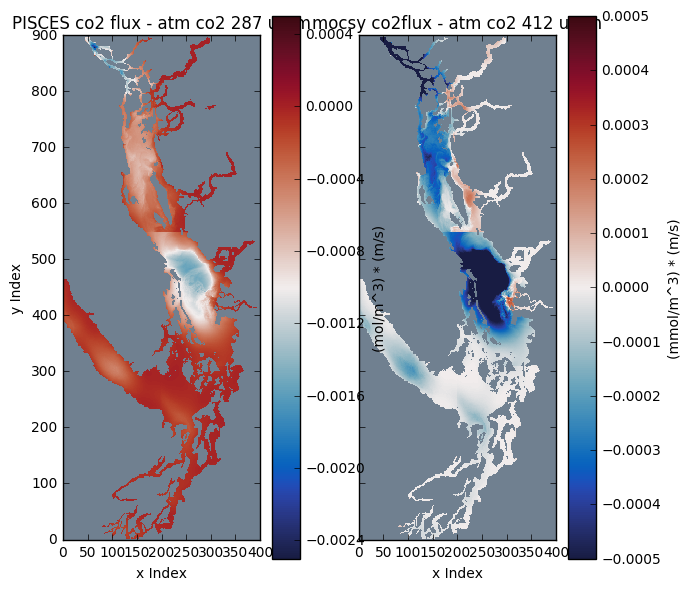

In [16]:
VP.two_panel_plot(oce_co2,f_co2flux,'PISCES co2 flux - atm co2 287 uatm','mocsy co2flux - atm co2 412 uatm',\
                  cm.cm.balance,7,7,-0.0025,0.0005,-0.0005,0.0005,'(mol/m^3) * (m/s)','(mmol/m^3) * (m/s)','')

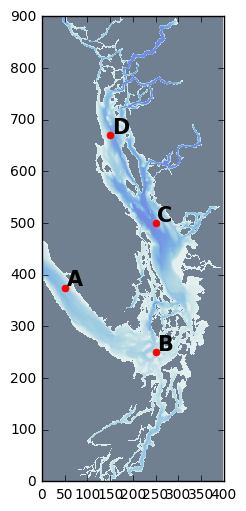

In [13]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
bathy = mesh.variables['Bathymetry'][:]

itt = [50,250,250,150]
jtt = [375,250,500,670]
wtt = ['A','B','C','D']
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(bathy, cmap=cmocean.cm.dense, vmin = 0, vmax = 1000)
for w in range(0,len(wtt)):

        ax.plot(itt[w],jtt[w],'r.',markersize=10)
        ax.text(itt[w]+4,jtt[w]+4,wtt[w],fontsize=15,weight='bold')

In [14]:
#o2 conc, temp, sal, schmidt number, wind mag, pist_vel, 
itt = [50.0,250.0,250,150]
jtt = [375,250,500,670]
temptt = np.zeros_like(itt)
saltt = np.zeros_like(itt)
windtt = np.zeros_like(itt)
schtt = np.zeros_like(itt)
pisttt= np.zeros_like(itt)
o2_conc = np.zeros_like(itt)
o2_sol  = np.zeros_like(itt)
o2_flx = np.zeros_like(itt)
itt = [50,250,250,150]

for w in range(0,len(itt)):
    temptt[w] = temp[jtt[w],itt[w]]
    saltt[w]= sal[jtt[w],itt[w]]
    windtt[w]= wm[jtt[w],itt[w]]
    ztc = temptt[w]
    sc_o2  = 1920.4 - 135.6  * ztc + 5.2122 * ztc**2 - 0.109390 * ztc**3 + 0.0009377 * ztc**4
    schtt[w] = sc_o2
    pisttt[w] = zkgo2[jtt[w],itt[w]]
    o2_sol[w] = chemo2[jtt[w],itt[w]]
    o2_flx[w] = oce_o2[jtt[w],itt[w]]
    o2_conc[w] = o2_surf[jtt[w],itt[w]]


NameError: name 'zkgo2' is not defined

In [ ]:
import pandas as pd
dataset = pd.DataFrame({'i':itt,'j':jtt,'temp (C)':temptt,\
                        'sal':saltt,'schmidt':schtt,'wind (m/s)':windtt,\
                       'pist.vel.(m/s)':pisttt,'o2 sol (mol/(L atm))':o2_sol,\
                        'o2 flux (mol/L) * (m/s)':o2_flx,'surface o2 (umol/L)':o2_conc})
print(dataset)
